<a href="https://colab.research.google.com/github/jrtrj/ImageSharpening_KD/blob/improved/ImageSharpening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-msssim
!pip install albumentations==1.3.1

import os
import cv2
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from pytorch_msssim import ssim as ssim_loss
import albumentations as A
from albumentations.pytorch import ToTensorV2
from skimage.metrics import structural_similarity as ssim
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
class DIV2KDatasetAugmented(Dataset):
    def __init__(self, hr_dir):
        self.hr_paths = sorted(glob.glob(os.path.join(hr_dir, "*.png")))
        self.degradation_transform = A.Compose([
            A.OneOf([
                A.GaussianBlur(blur_limit=(3, 7), p=0.7),
                A.MotionBlur(blur_limit=(3, 7), p=0.3),
            ], p=1.0),
            A.Downscale(scale_min=0.6, scale_max=0.8, interpolation=cv2.INTER_CUBIC, p=0.5),
            A.GaussNoise(var_limit=(10, 50), p=0.3),
        ])

        self.to_tensor = A.Compose([
            A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
            A.pytorch.ToTensorV2()
        ])

    def __len__(self):
        return len(self.hr_paths)

    def __getitem__(self, idx):
        img_hr_np = cv2.imread(self.hr_paths[idx])
        img_hr_np = cv2.cvtColor(img_hr_np, cv2.COLOR_BGR2RGB)
        img_hr_np = cv2.resize(img_hr_np, (128, 128))

        img_degraded_np = self.degradation_transform(image=img_hr_np)['image']

        img_hr = self.to_tensor(image=img_hr_np)['image']
        img_degraded = self.to_tensor(image=img_degraded_np)['image']

        return img_degraded, img_hr

In [3]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, 3, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.act(self.pointwise(self.depthwise(x)))

class StudentBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = DepthwiseSeparableConv(channels, channels)
        self.conv2 = DepthwiseSeparableConv(channels, channels)

    def forward(self, x):
        return x + self.conv2(self.conv1(x))

class StudentCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.entry = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

        self.blocks = nn.Sequential(
            StudentBlock(32),
            StudentBlock(32),
            StudentBlock(32)
        )

        self.exit = nn.Conv2d(32, 3, kernel_size=3, padding=1)

    def forward(self, x):
        out = self.relu(self.entry(x))
        out = self.blocks(out)
        out = self.exit(out)
        return x + out  # Residual output like teacher


In [9]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(x + out)

class ResNetSharpen(nn.Module):
    def __init__(self, num_blocks=8):
        super(ResNetSharpen, self).__init__()
        self.conv_in = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.residual_layers = nn.Sequential(
            *[ResidualBlock(64) for _ in range(num_blocks)]
        )
        self.conv_out = nn.Conv2d(64, 3, kernel_size=3, padding=1)

    def forward(self, x):
        identity = x
        out = self.relu(self.conv_in(x))
        out = self.residual_layers(out)
        out = self.conv_out(out)
        return identity + out


In [4]:
# Perceptual Loss using a pre-trained VGG19
from torchvision.models import vgg19, VGG19_Weights

class VGGPerceptualLoss(nn.Module):
    def __init__(self):
        super(VGGPerceptualLoss, self).__init__()
        weights = VGG19_Weights.DEFAULT
        vgg = vgg19(weights=weights).features.to(device).eval()
        for param in vgg.parameters(): param.requires_grad = False
        self.feature_extractor = nn.Sequential(*list(vgg.children())[:36])
        self.loss_fn = nn.L1Loss()

    def forward(self, pred, target):
        pred_features = self.feature_extractor(pred)
        target_features = self.feature_extractor(target)
        return self.loss_fn(pred_features, target_features)

# A total loss function combining all criteria
class TotalLoss(nn.Module):
    def __init__(self, ssim_w=0.8, perceptual_w=0.01):
        super(TotalLoss, self).__init__()
        self.ssim_w = ssim_w
        self.perceptual_w = perceptual_w
        self.mse = nn.MSELoss()
        self.ssim = lambda p, t: 1 - ssim_loss(p, t, data_range=1.0, size_average=True)
        self.perceptual = VGGPerceptualLoss()

    def forward(self, pred, target):
        ssim_mse_loss = self.ssim_w * self.ssim(pred, target) + (1 - self.ssim_w) * self.mse(pred, target)
        perceptual_loss = self.perceptual(pred, target)
        return ssim_mse_loss + self.perceptual_w * perceptual_loss

In [5]:
# Download and extract DIV2K_train_HR.zip
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

# Extract the contents
!unzip DIV2K_train_HR.zip -d DIV2K_train_HR

# Optional: Clean up the zip file to save space
!rm DIV2K_train_HR.zip


--2025-07-12 14:41:00--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2025-07-12 14:41:00--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  19.3MB/s    in 3m 3s   

2025-07-12 14:44:04 (18.4 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]

Archive:  DIV2K_train_HR.zip
   creating: DIV2K_train_HR/DIV2K_train_HR/
  inflating: DIV2K_train_HR/DIV2K_train_HR/

In [6]:
data_dir = "/content/DIV2K_train_HR/DIV2K_train_HR"
full_dataset = DIV2KDatasetAugmented(data_dir)

# 90% for training, 10% for validation
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size

generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 720
Validation samples: 80


In [7]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [10]:
# : Train the Teacher Model ---

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model = ResNetSharpen(num_blocks=8).to(device)

criterion = TotalLoss(ssim_w=0.8, perceptual_w=0.01).to(device)
optimizer = optim.Adam(teacher_model.parameters(), lr=1e-4)
epochs = 20
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

print("--- Starting Training for the teacher Model ---")

def evaluate_ssim(model, loader):
    print("Evaluating SSIM...")
    model.eval()
    total_ssim = 0
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            score = ssim_loss(outputs, targets, data_range=1.0, size_average=True)
            total_ssim += score.item() * inputs.size(0)
            count += inputs.size(0)
    return total_ssim / count


for epoch in range(epochs):
    teacher_model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = teacher_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    train_loss = running_loss / len(train_loader)

    val_ssim = evaluate_ssim(teacher_model, val_loader)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.5f} | Val SSIM: {val_ssim:.4f}")

torch.save(teacher_model.state_dict(), "teacher.pth")

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 74.2MB/s]


--- Starting Training for the teacher Model ---
Evaluating SSIM...
Epoch 1/20 | Train Loss: 0.58311 | Val SSIM: 0.4837
Evaluating SSIM...
Epoch 2/20 | Train Loss: 0.39862 | Val SSIM: 0.5642
Evaluating SSIM...
Epoch 3/20 | Train Loss: 0.36125 | Val SSIM: 0.5568
Evaluating SSIM...
Epoch 4/20 | Train Loss: 0.34280 | Val SSIM: 0.6041
Evaluating SSIM...
Epoch 5/20 | Train Loss: 0.34365 | Val SSIM: 0.5602
Evaluating SSIM...
Epoch 6/20 | Train Loss: 0.32596 | Val SSIM: 0.5815
Evaluating SSIM...
Epoch 7/20 | Train Loss: 0.33052 | Val SSIM: 0.5760
Evaluating SSIM...
Epoch 8/20 | Train Loss: 0.33387 | Val SSIM: 0.6087
Evaluating SSIM...
Epoch 9/20 | Train Loss: 0.32196 | Val SSIM: 0.6266
Evaluating SSIM...
Epoch 10/20 | Train Loss: 0.31396 | Val SSIM: 0.6010
Evaluating SSIM...
Epoch 11/20 | Train Loss: 0.31037 | Val SSIM: 0.5973
Evaluating SSIM...
Epoch 12/20 | Train Loss: 0.30358 | Val SSIM: 0.6278
Evaluating SSIM...
Epoch 13/20 | Train Loss: 0.30753 | Val SSIM: 0.6258
Evaluating SSIM...
Epoch 

In [ ]:
teacher_model.load_state_dict(torch.load("teacher.pth"))
teacher_model.eval()

student_model = StudentCNN().to(device)
optimizer = optim.Adam(student_model.parameters(), lr=1e-4)
distill_epochs = 20

def distillation_loss(s_out, t_out, target, alpha=0.75):
    loss_teacher = nn.MSELoss()(s_out, t_out)
    loss_gt = nn.MSELoss()(s_out, target)
    return alpha * loss_teacher + (1 - alpha) * loss_gt

print("\n--- Starting Knowledge Distillation from Teacher ---")

for epoch in range(distill_epochs):
    student_model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        with torch.no_grad():
            teacher_out = teacher_model(inputs)

        student_out = student_model(inputs)

        loss = distillation_loss(student_out, teacher_out, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    student_val_ssim = evaluate_ssim(student_model, val_loader)
    print(f"[Student] Epoch {epoch+1}/{distill_epochs} | Val SSIM: {student_val_ssim:.4f}")

torch.save(student_model.state_dict(), "student_final.pth")


--- Starting Knowledge Distillation from Teacher ---
Evaluating SSIM...
[Student] Epoch 1/20 | Val SSIM: 0.5514
Evaluating SSIM...
[Student] Epoch 2/20 | Val SSIM: 0.5667
Evaluating SSIM...
[Student] Epoch 3/20 | Val SSIM: 0.5704
Evaluating SSIM...
[Student] Epoch 4/20 | Val SSIM: 0.5595
Evaluating SSIM...
[Student] Epoch 5/20 | Val SSIM: 0.5836
Evaluating SSIM...
[Student] Epoch 6/20 | Val SSIM: 0.5793
Evaluating SSIM...
[Student] Epoch 7/20 | Val SSIM: 0.5880
Evaluating SSIM...
[Student] Epoch 8/20 | Val SSIM: 0.6014
Evaluating SSIM...
[Student] Epoch 9/20 | Val SSIM: 0.5850
Evaluating SSIM...
[Student] Epoch 10/20 | Val SSIM: 0.5968



--- Final Model Performance on the Unseen Validation Set ---
Evaluating SSIM...
Evaluating SSIM...
Teacher SSIM: 0.6312
Distilled Student SSIM: 0.6061

--- Visualizing Model Outputs ---


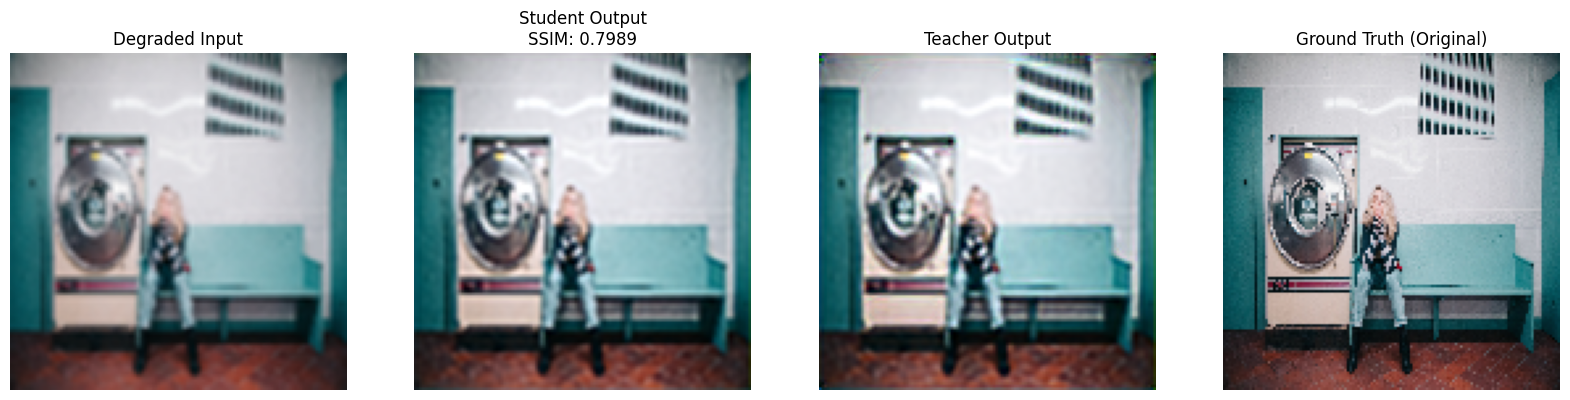

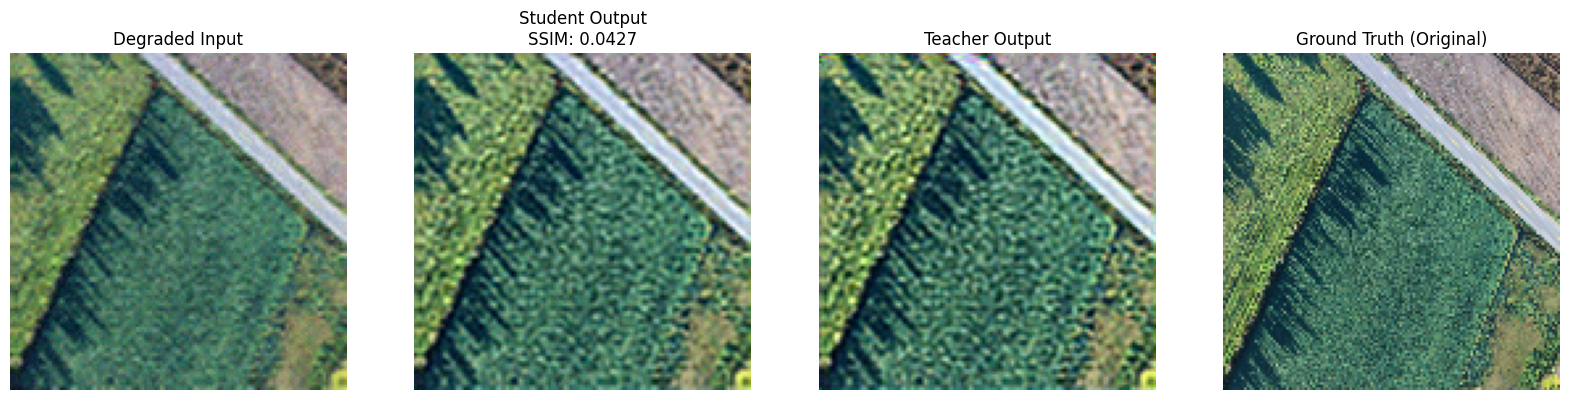

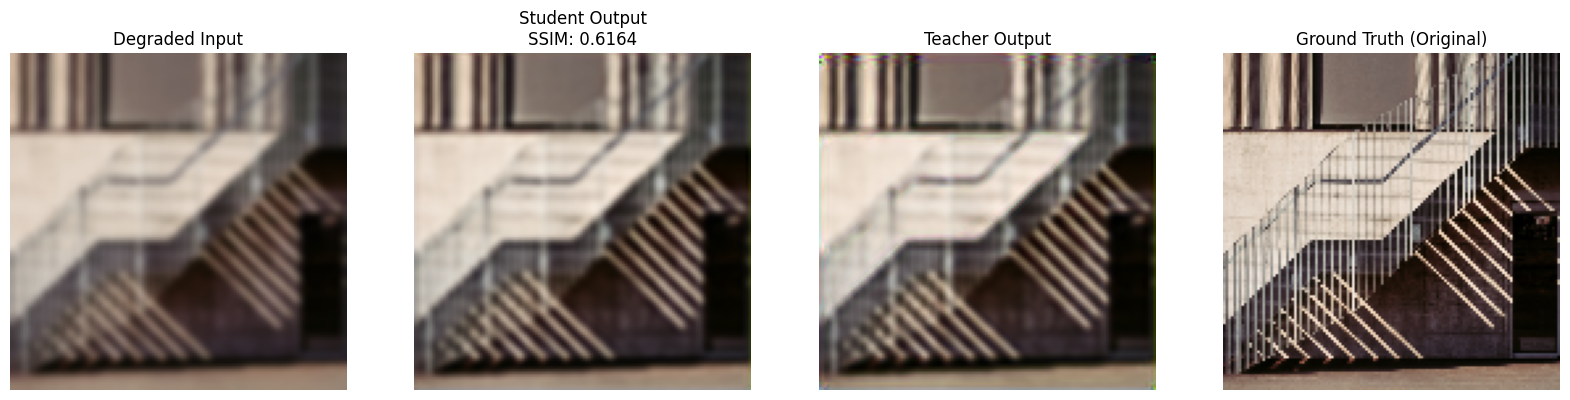

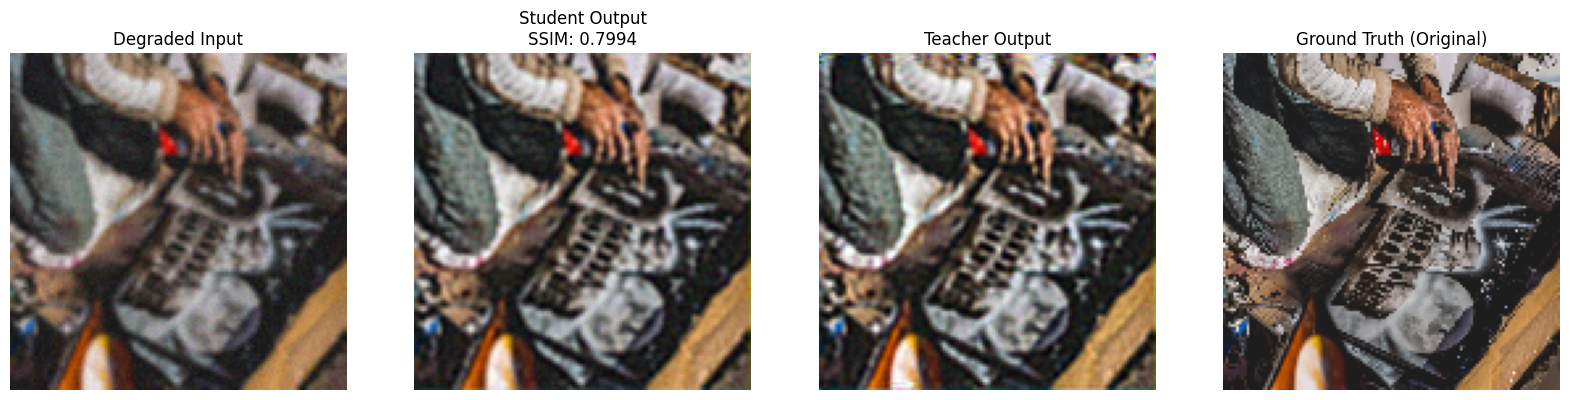

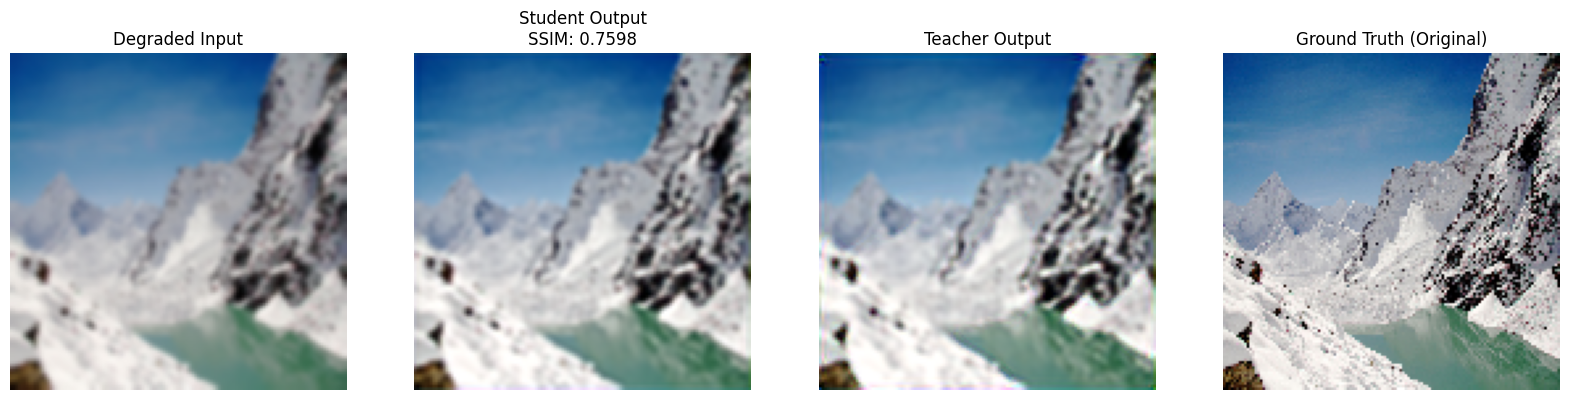

In [ ]:
teacher_model.eval()
student_model.eval()

print("\n--- Final Model Performance on the Unseen Validation Set ---")

final_teacher_ssim = evaluate_ssim(teacher_model, val_loader)
final_student_ssim = evaluate_ssim(student_model, val_loader)

print(f"Teacher SSIM: {final_teacher_ssim:.4f}")
print(f"Distilled Student SSIM: {final_student_ssim:.4f}")


def visualize_results(dataset, num_images=5):
    print("\n--- Visualizing Model Outputs ---")

    for i in range(num_images):
        input_img, target_img = dataset[i]

        input_tensor = input_img.unsqueeze(0).to(device)

        with torch.no_grad():
            student_out = student_model(input_tensor)
            teacher_out = teacher_model(input_tensor)

        input_np = np.clip(input_img.cpu().permute(1, 2, 0).numpy(), 0, 1)
        target_np = np.clip(target_img.cpu().permute(1, 2, 0).numpy(), 0, 1)
        student_np = np.clip(student_out.squeeze(0).cpu().permute(1, 2, 0).numpy(), 0, 1)
        teacher_np = np.clip(teacher_out.squeeze(0).cpu().permute(1, 2, 0).numpy(), 0, 1)

        ssim_score = ssim(target_np, student_np, channel_axis=2, data_range=1.0)

        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        axes[0].imshow(input_np)
        axes[0].set_title("Degraded Input")
        axes[0].axis("off")

        axes[1].imshow(student_np)
        axes[1].set_title(f"Student Output\nSSIM: {ssim_score:.4f}")
        axes[1].axis("off")

        axes[2].imshow(teacher_np)
        axes[2].set_title("Teacher Output")
        axes[2].axis("off")

        axes[3].imshow(target_np)
        axes[3].set_title("Ground Truth (Original)")
        axes[3].axis("off")

        plt.show()

visualize_results(val_dataset)